# Week 1

For Week 1 Stock Analysis I focused on gaining an understanding of the S&P 500.

Specifically stocks that are undervalued and also gaining value.

My analysis is broken down as:

1. S&P 500
2. yfinance
3. Stocks that are Gaining Value sorted by Value
4. Undervalued Stocks sorted by Gain
5. What to buy?

## S&P 500

Lets first look at the S&P 500 to see what stocks they cover.

We will be using [slickcharts](https://www.slickcharts.com/sp500) as they provide the data that we are looking for.

In [3]:
import requests
import pandas as pd

# Make a connection to slickcharts S&P 500 page
url = 'https://www.slickcharts.com/sp500'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36'}
request = requests.get(url, headers=headers)

# Get the table of information
html = request.content
df_list = pd.read_html(html)
df = df_list[0]
print(df)

       #                    Company Symbol    Weight    Price    Chg     % Chg
0      1      Microsoft Corporation   MSFT  6.424937   343.60   2.33   (0.68%)
1      2                 Apple Inc.   AAPL  6.210814   160.99   3.12   (1.98%)
2      3            Amazon.com Inc.   AMZN  4.032845  3672.16 -23.90  (-0.65%)
3      4      Alphabet Inc. Class A  GOOGL  2.260380  2978.75 -18.02  (-0.60%)
4      5                  Tesla Inc   TSLA  2.228760  1140.00  43.62   (3.98%)
..   ...                        ...    ...       ...      ...    ...       ...
501  502  Under Armour Inc. Class A    UAA  0.012803    26.96   0.13   (0.48%)
502  503  Under Armour Inc. Class C     UA  0.011192    22.63   0.03   (0.13%)
503  504     Discovery Inc. Class A  DISCA  0.010978    25.31  -1.54  (-5.74%)
504  505   News Corporation Class B    NWS  0.007236    22.32  -1.04  (-4.45%)
505  506     Orion Office REIT Inc.    ONL  0.000071    17.64  -0.24  (-1.34%)

[506 rows x 7 columns]


In [2]:
# Get symbols to lookup
symbols = df['Symbol']
print(symbols)

0       MSFT
1       AAPL
2       AMZN
3      GOOGL
4       TSLA
       ...  
501      UAA
502       UA
503    DISCA
504      NWS
505      ONL
Name: Symbol, Length: 506, dtype: object


## yfinance

Now that we know what symbols to look for, we can use [yfinance](https://pypi.org/project/yfinance/) in order to get data from Yahoo Finance.

**Since we are going through all of the S&P stocks, the process will take a long time. You can skip this step if you already have the output csv file.**

In [3]:
from collections import Counter
from statistics import mean
import yfinance as yf
import csv
import sys

# Allow data collection to be skipped due to it being a long process, 500+ stocks assessed
run = input('Collect data? (Yes): ')

if run == 'Yes':
    
    print('Beginning data collection')

    symbols = df['Symbol']
    df = df[['Symbol', 'Chg']].copy()

    with open('output.csv', 'w') as csv_file:

        writer = csv.writer(csv_file, delimiter=',', lineterminator='\n')
        writer.writerow(('Symbol', 'Historical Average', 'Current Price', 'Difference', 'Change'))
        
        i = 1
        for symbol in symbols:
            
            if i % 50 == 0:
                print(i, 'Stocks assessed')

            # Get 1 week of data
            ticker = yf.Ticker(symbol)
            history = ticker.history(interval='1wk')
            averages = []

            # Find average price
            for row in history.itertuples():
                average = (row.High + row.Low + row.Open + row.Close) / 4
                if pd.isnull(average) == False:
                    averages.append(average)

            if len(averages) == 0:
                continue

            historical = mean(averages)
            
            try:
                current = ticker.info['regularMarketPrice']
            except KeyError:
                continue
            
            difference = current - historical

            # Check how stock is growing
            change = df.loc[df['Symbol'] == symbol, 'Chg'].item()

            writer.writerow((symbol, historical, current, difference, change))
            i += 1
    
    print('Finished data collection')

else:
    
    print('Data collection skipped')

Collect data? (Yes): Yes
Beginning data collection
- BRK.B: No data found, symbol may be delisted
50 Stocks assessed
100 Stocks assessed
150 Stocks assessed
200 Stocks assessed
250 Stocks assessed
300 Stocks assessed
350 Stocks assessed
400 Stocks assessed
- BF.B: None
450 Stocks assessed
500 Stocks assessed
Finished data collection


## Stocks that are Gaining Value sorted by Value

Lets first look for stocks that are both undervalued and gaining value.

1. We first look at stocks with a negative difference. That is their current value is below the calculated 1 week average.

In [4]:
df = pd.read_csv('output.csv')

# Look for stocks that are undervalued
by_difference = df[['Symbol', 'Difference', 'Change']].copy()
by_difference = by_difference.sort_values(by='Difference')
print(by_difference.head(10))

    Symbol  Difference  Change
85    BKNG  -75.875204  -35.99
320   PAYC  -39.515291    1.12
291   GNRC  -33.700831   17.89
89    MRNA  -28.105000   11.17
160    CMG  -27.724374  -25.17
416   MKTX  -26.922501   -5.83
25    PYPL  -25.586043   -6.50
143   ILMN  -21.792088    3.42
364    FLT  -21.212498    0.38
399    TFX  -20.897414  -11.49


2. Then we can get rid of stocks that are losing value to see which ones are gaining value.

In [5]:
# Remove stocks that are losing value
by_difference.drop(by_difference[by_difference['Change'] < 0].index, inplace = True)
print(by_difference.head(20))

    Symbol  Difference  Change
320   PAYC  -39.515291    1.12
291   GNRC  -33.700831   17.89
89    MRNA  -28.105000   11.17
143   ILMN  -21.792088    3.42
364    FLT  -21.212498    0.38
150    NOC  -16.713331    1.71
71     AMT  -13.899166    1.04
218    GPN  -12.865624    0.77
338    WAT  -10.998120    7.35
212   BIIB  -10.732917    0.71
452   JKHY   -9.717502    1.41
123    AON   -9.551189    1.96
352    COO   -9.073336    0.18
358   TECH   -8.642920    6.37
267   WLTW   -8.096668    5.78
181    LHX   -8.049493    0.00
459   CTXS   -7.430742    0.37
122    FIS   -6.683333    0.93
437    PTC   -6.563333    0.54
146   IDXX   -6.113958   13.27


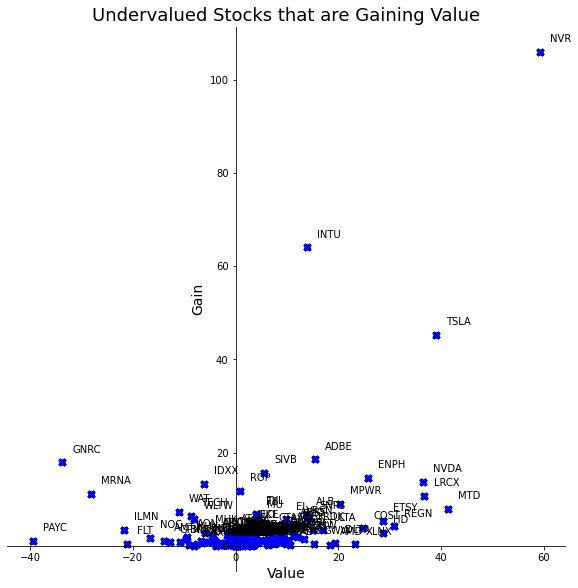

In [10]:
import matplotlib.pyplot as plt

# Make a scatter plot
x = by_difference['Difference'].values
y = by_difference['Change'].values
sym = by_difference.reset_index()['Symbol'].values

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y)

ax.set_xlabel('Value', fontsize=14)
ax.set_ylabel('Gain', fontsize=14)
ax.set_title('Undervalued Stocks that are Gaining Value', fontsize=18)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

for i, text in enumerate(sym):
    ax.annotate(text, (x[i], y[i]), xytext=(10, 10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='blue')

plt.savefig('undervalued_gains.png', bbox_inches='tight')

## Undervalued Stocks sorted by Gain

Now lets look for undervalued stocks that are gaining value.

1. Simply sort by `Change` in descending order.

In [7]:
# Look for stocks that are growing in value
by_change = df[['Symbol', 'Difference', 'Change']].copy()
by_change = by_change.sort_values(by='Change', ascending=False)
print(by_change.head(10))

    Symbol  Difference  Change
382    NVR   59.195363  106.02
48    INTU   13.832291   64.01
4     TSLA   39.063744   45.32
15    ADBE   15.441669   18.53
291   GNRC  -33.700831   17.89
183   SIVB    5.558956   15.60
239   ENPH   25.735834   14.52
7     NVDA   36.458751   13.76
146   IDXX   -6.113958   13.27
156    ROP    0.759583   11.77


2. Then remove overvalued stocks.

In [8]:
# Remove stocks that are overvalued
by_change.drop(by_change[by_change['Difference'] > 0].index, inplace = True)
print(by_change.head(20))

    Symbol  Difference  Change
291   GNRC  -33.700831   17.89
146   IDXX   -6.113958   13.27
89    MRNA  -28.105000   11.17
338    WAT  -10.998120    7.35
358   TECH   -8.642920    6.37
267   WLTW   -8.096668    5.78
143   ILMN  -21.792088    3.42
442    ATO   -0.835584    3.10
462    MHK   -5.869583    2.78
259    AWK   -0.149341    2.44
438   CHRW   -1.744791    2.36
124    APD   -4.346665    2.26
283    URI   -1.002082    2.13
72    AMGN   -4.664376    2.06
123    AON   -9.551189    1.96
150    NOC  -16.713331    1.71
417    LNT   -0.857312    1.54
452   JKHY   -9.717502    1.41
351     BR   -4.017709    1.13
320   PAYC  -39.515291    1.12


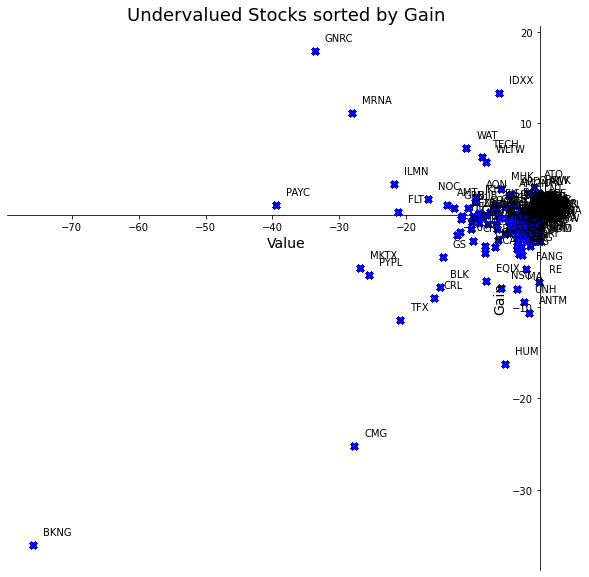

In [11]:
# Make another scatter plot
x = by_change['Difference'].values
y = by_change['Change'].values
sym = by_change.reset_index()['Symbol'].values

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y)

ax.set_xlabel('Value', fontsize=14)
ax.set_ylabel('Gain', fontsize=14)
ax.set_title('Undervalued Stocks sorted by Gain', fontsize=18)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

for i, text in enumerate(sym):
    ax.annotate(text, (x[i], y[i]), xytext=(10, 10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='blue')

plt.savefig('stock_gains.png', bbox_inches='tight')

## What to buy?

I think that the following stocks have a good balance between being undervalued and gaining value.

1. GNRC
2. MRNA
3. ILMN
4. IDXX
5. SYK

I focused on buying stocks that were undervalued because you are not overpaying for the stock.

I then focused on stocks that were gaining value hoping to cash in on their gains.